<a href="https://colab.research.google.com/github/juanmg1984/dm2025a/blob/main/Pinecone%202%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalar dependencias
!pip install pandas scikit-learn pinecone


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.6/587.6 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.3/259.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0


In [1]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

# Load the iris dataset
iris = load_iris()
X = iris.data
y = iris.target  # Optional: keep track of the target labels

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#X_scaled = X

print("Iris dataset loaded and scaled. Shape:", X_scaled.shape)

Iris dataset loaded and scaled. Shape: (150, 4)


In [ ]:
from dotenv import load_dotenv
# Cargar las variables de entorno desde el archivo .env
load_dotenv()

True

In [4]:
import pinecone
import os
from pinecone import Pinecone, ServerlessSpec # Import Pinecone and ServerlessSpec
from google.colab import userdata # Import userdata to access Colab secrets

# Assuming you set PINECONE_API_KEY in environment variables or Colab secrets
PINECONE_API_SECRET = userdata.get("PINECONE_API_KEY")
PINECONE_ENVIRONMENT = os.getenv("pinecone_environment") # Assuming you set PINECONE_ENVIRONMENT
PINECONE_INDEX = os.getenv("db_name") # Assuming you set PINECONE_INDEX

# Initialize Pinecone by creating an instance of the Pinecone class
pc = Pinecone(api_key=PINECONE_API_SECRET)

print("Pinecone initialized.")

# You can now use the 'pc' object to interact with Pinecone, for example:
# index_list = pc.list_indexes()
# print("Existing indexes:", index_list)

Pinecone initialized.


In [5]:
# Delete the index when you are finished
index_name="dataset-numerico-demo"
pc.delete_index(index_name)
print(f"Index '{index_name}' deleted.")

Index 'dataset-numerico-demo' deleted.


In [6]:
index_name = "dataset-numerico-demo"
# Crear índice si no existe
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=X_scaled.shape[1],
        metric="euclidean",  # o "euclidean" u otra, según tu caso
         spec=ServerlessSpec(cloud='aws', region='us-east-1') # Add this line to specify the serverless spec
    )

index = pc.Index(index_name)

In [7]:
X_scaled.shape[1]

4

In [8]:
# — Paso 4: insertar vectores con metadatos
batch_size = 100
for i in range(0, len(X_scaled), batch_size):
    batch_vectors = X_scaled[i : i + batch_size]
    # preparar lista de tuplas (id, vector, metadata)
    to_upsert = []
    for j, vec in enumerate(batch_vectors):
        idx = i + j
        # Agregar metadatos, incluyendo el índice de fila y la especie
        metadata = {"row_index": idx, "species": int(y[idx])} # Assuming y contains the species labels
        to_upsert.append( (str(idx), vec.tolist(), metadata) )
    index.upsert(vectors=to_upsert)

In [9]:
print("Inserción finalizada. Total de vectores:", len(X_scaled))

# — Paso 5: consulta de ejemplo
# Tomar un vector de la base como consulta
query_vec = X_scaled[0]*2
top_k = index.query(vector=query_vec.tolist(), top_k=5, include_metadata=True)
print("Resultados similares:", top_k)

# (opcional) borrar índice al terminar
# pinecone.delete_index(index_name)

Inserción finalizada. Total de vectores: 150
Resultados similares: {'matches': [], 'namespace': '', 'usage': {'read_units': 1}}


In [10]:
X_scaled[100]


array([0.55333328, 0.55861082, 1.27429511, 1.71209594])

In [11]:
 X_scaled[0]

array([-0.90068117,  1.01900435, -1.34022653, -1.3154443 ])

In [12]:
X_scaled[17]

array([-0.90068117,  1.01900435, -1.34022653, -1.18381211])

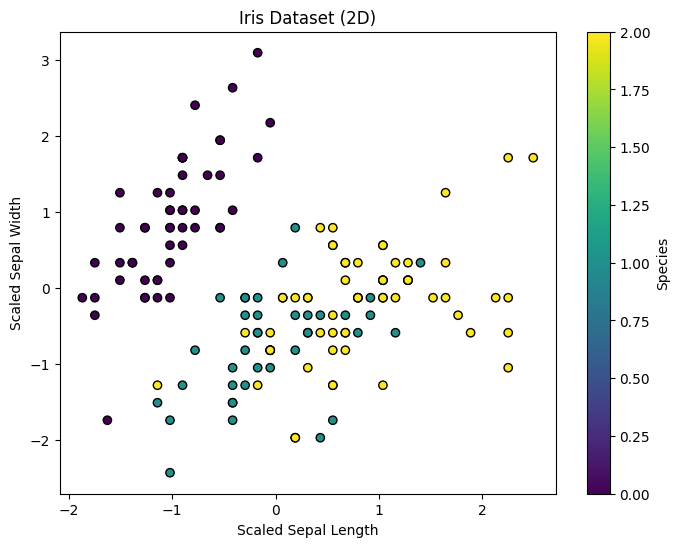

In [13]:
import matplotlib.pyplot as plt

# Plot the scaled data
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='viridis', edgecolors='k')
plt.xlabel('Scaled Sepal Length')
plt.ylabel('Scaled Sepal Width')
plt.title('Iris Dataset (2D)')
plt.colorbar(label='Species')
plt.show()

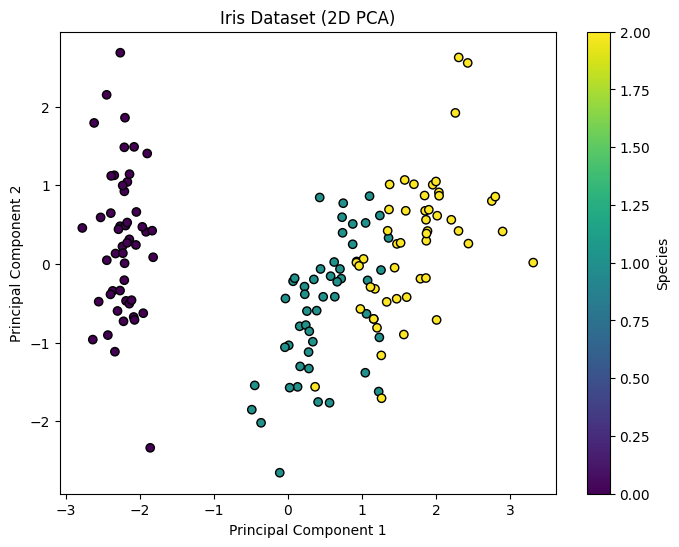

In [14]:
from sklearn.decomposition import PCA

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the PCA-transformed data
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolors='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Iris Dataset (2D PCA)')
plt.colorbar(label='Species')
plt.show()

In [15]:
# Function to perform KNN using Pinecone
def pinecone_knn_predict(query_vector, k, index, y_labels):
    """
    Performs KNN prediction using Pinecone index.

    Args:
        query_vector (list): The vector to query for neighbors.
        k (int): The number of nearest neighbors to retrieve.
        index: The Pinecone index object.
        y_labels (numpy.ndarray): The original labels for the dataset.

    Returns:
        int: The predicted class label.
    """
    # Query Pinecone for nearest neighbors
    results = index.query(vector=query_vector, top_k=k, include_metadata=True)

    # Get the indices of the nearest neighbors
    neighbor_indices = [int(match['metadata']['row_index']) for match in results['matches']]

    # Get the labels of the nearest neighbors
    neighbor_labels = y_labels[neighbor_indices]

    # Perform majority voting to predict the class
    from collections import Counter
    label_counts = Counter(neighbor_labels)
    predicted_class = label_counts.most_common(1)[0][0]

    return predicted_class

# Example usage:
# Let's use the first vector from X_scaled as a query vector
query_vec_example = X_scaled[100].tolist()
k_neighbors = 1

predicted_class_example = pinecone_knn_predict(query_vec_example, k_neighbors, index, y)

print(f"Query vector: {query_vec_example}")
print(f"Predicted class (using Pinecone KNN): {predicted_class_example}")
print(f"Actual class: {y[0]}")

# You can extend this to test on multiple query vectors from X_scaled
# For a more robust evaluation, you would typically split your data into
# training and testing sets before inserting into Pinecone and querying.

Query vector: [0.5533332750260058, 0.5586108194543131, 1.2742951114029808, 1.712095943669179]
Predicted class (using Pinecone KNN): 2
Actual class: 0


In [16]:
# Example of using the pinecone_knn_predict function
# Let's use a vector from the dataset as a query to test the prediction
query_vector_to_predict = X_scaled[105].tolist() # Using the vector at index 105 as an example query
k_neighbors_for_prediction = 5 # Set the number of neighbors to consider for prediction

predicted_class = pinecone_knn_predict(query_vector_to_predict, k_neighbors_for_prediction, index, y)

print(f"Query vector: {query_vector_to_predict}")
print(f"Number of neighbors (k): {k_neighbors_for_prediction}")
print(f"Predicted class based on metadata of neighbors: {predicted_class}")
print(f"Actual class of the query vector: {y[105]}")

Query vector: [2.1285155907934725, -0.1319794793216258, 1.6153196728845993, 1.1855672065079756]
Number of neighbors (k): 5
Predicted class based on metadata of neighbors: 2
Actual class of the query vector: 2
